# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, fbeta_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pprint import pprint
import visuals as vs

%matplotlib inline


In [8]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Visualization

In [11]:
def plot_percentages(stat):
    """
    This function is used to plot top (=<10) unique values of a feature against their percentages

    stat: Dataframe. A dataframe containing unique values of a feature along with
    their counts and precentages

    """
    if stat.shape[0] > 10:
        plt.barh(stat.iloc[0:9, 0], stat.iloc[0:9, 2])
    else:
        plt.barh(stat.iloc[:, 0], stat.iloc[:, 2])
        
    plt.xlabel('percentage')
    plt.ylabel(stat.columns[0])
        
        
def plot_continuous_features(feature, dataframe):
    """
    This function is used to plot a histogram of a continuous feature

    feature: string. feature name
    datafram: the dataframe containging this feature as a column

    """
    display(dataframe[feature].describe())
    plt.hist(dataframe[feature], bins=30)
    plt.xlabel(feature)
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

        

def feature_stat_single(feature_name, df):
    """
    This function is used to take all unique values from a feature and create a new dataframe containing 
    these values along with their frequency and percentage of occurance

    feature_name: string. feature name
    df: the dataframe containging this feature
    
    Returns:

    feature_value_counts: Dataframe. Dataframe containing counts and percentage of unique values in
    the input feature.

    """
    feature_value_counts = df[feature_name].value_counts().reset_index()
    feature_value_counts.rename(columns={'index': feature_name, feature_name: 'count'}, inplace=True)
    feature_value_counts['percentage'] = feature_value_counts['count']/np.sum(feature_value_counts['count']) * 100
    plot_percentages(feature_value_counts)
    display(feature_value_counts)
    return feature_value_counts
 

pd.options.mode.chained_assignment = None

### Offers Dataset: portfolio

In [4]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


- there are 10 different offers in the dataset which are either informational, discount or bogo (buy one get one free) offers. 
- They are communicated through different communication platforms: web, email, mobile and social.

### Customers Dataset : profile

In [5]:
print("Total number of rows: {} , columns: {}".format(profile.shape[0],profile.shape[1]))
profile.head()

Total number of rows: 17000 , columns: 5


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
#number of duplicated values
profile.duplicated().sum()

0

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

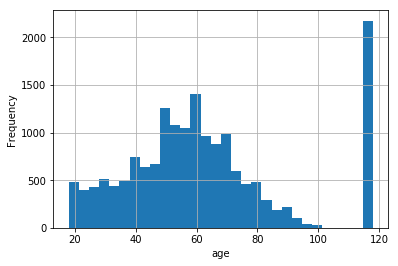

In [7]:
# plot hist of Age
plot_continuous_features('age',profile);

In [8]:
# invistigate age 118 
age_118 = profile[profile['age'] == 118]

In [9]:
age_118.head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


it seems like this value '118' represents the missing values. To confirm, I will print all unique values for gender and income when age = 118 to make sure we only have None values. Also I will make sure that we only have missing values when age = 118

In [10]:
age_118['gender'].unique()

array([None], dtype=object)

In [11]:
age_118['income'].unique()

array([nan])

In [12]:
print('number of missing data in the profile dataframe: {}'.format(age_118.shape[0]))

number of missing data in the profile dataframe: 2175


In [13]:
profile[pd.isnull(profile['income'])].shape[0]

2175

In [14]:
profile[pd.isnull(profile['gender'])].shape[0]

2175

In [15]:
#percentage of missing values
profile_missing_values_perc = age_118.shape[0] / profile.shape[0]
display(profile_missing_values_perc)

0.12794117647058822

,gender,count,percentage
0,M,8484,57.227656
1,F,6129,41.342327
2,O,212,1.430017


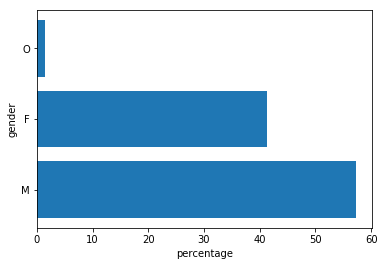

In [16]:
#distribution of gender in the dataset
feature_stat_single('gender', profile);

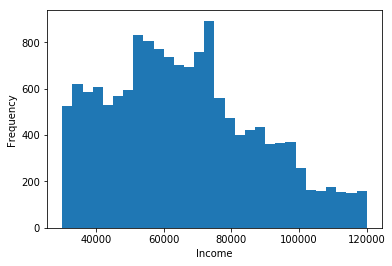

In [17]:
#histogram of income
plt.hist(profile[~ (pd.isnull(profile['income']))]['income'].values, bins = 30);
plt.xlabel('Income');
plt.ylabel('Frequency');

In [18]:
# statistics of the 'income' column
profile['income'].describe()

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

- Around 12.8% of the values in Profile dataset are missing at 2175 records where age=118, gender=None & income=NaN
- Approximately 1.4% of the customers chose 'O' which is a shortcut of Others that are not female of male.
- 50% of the employees recieve an average income of 64000
- The number of male customers are 16% higher than the female cutomers.

### Logs Dataset : transcript

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
#no missing values
transcript.isna().sum()

event     0
person    0
time      0
value     0
dtype: int64

,event,count,percentage
0,transaction,138953,45.330371
1,offer received,76277,24.883700
2,offer viewed,57725,18.831516
3,offer completed,33579,10.954413


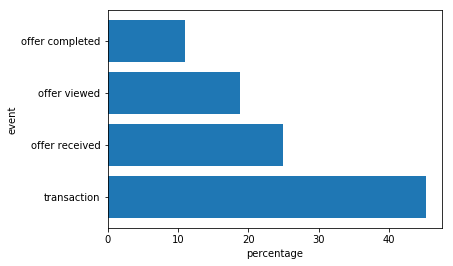

In [21]:
#distribution of the event type column
feature_stat_single('event', transcript);

count    306534.000000
mean        366.382940
std         200.326314
min           0.000000
25%         186.000000
50%         408.000000
75%         528.000000
max         714.000000
Name: time, dtype: float64

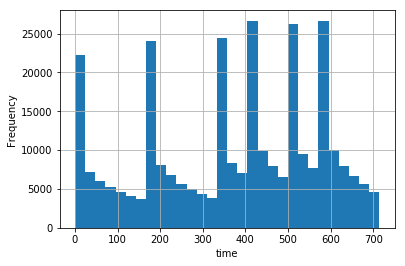

In [22]:
plot_continuous_features('time', transcript)

# Data Wrangling

### portfolio

In [23]:
#one hot encoding for column 'channels'
portfolio=portfolio.join(portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_'))

In [24]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [25]:
#remove column 'channels' as its information are already captured in other columns
portfolio=portfolio.drop('channels',axis=1)

In [26]:
#one hot encoding for column 'offer_type'
portfolio = portfolio.join(portfolio['offer_type'].str.get_dummies().add_prefix('offerType_'))

In [27]:
portfolio

,difficulty,duration,id,offer_type,reward,channel_email,channel_mobile,channel_social,channel_web,offerType_bogo,offerType_discount,offerType_informational
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0,1,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,1,0,0
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1,0,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1,1,0,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1,0,1,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,0,1,0
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,0,1,0
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,1,1,1,0,0,0,1
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,1,0,0
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,0,1,0,1,0


### profile

In [28]:
#remove missing data from profile dataset
profile_clean = profile[profile['age'] != 118]

In [29]:
profile_clean[profile_clean['age'] == 118].shape[0]

0

In [30]:
#remove 'O' values from gender column in profile dataset
profile_clean = profile_clean[profile_clean['gender'] !='O' ]

In [31]:
profile_clean['gender'].unique()

array(['F', 'M'], dtype=object)

In [32]:
# get the year customers joined the app in a seperate column
profile_clean['membership_year'] = profile_clean.became_member_on.apply(lambda x: str(x)[:4])
profile_clean['became_member_on'] = profile_clean.became_member_on.apply(lambda x: datetime.datetime.strptime(str(x),'%Y%m%d').date())

In [33]:
profile_clean.head()

,age,became_member_on,gender,id,income,membership_year
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017


In [34]:
#one hot encoding for membership_year
profile_clean = profile_clean.join(profile_clean['membership_year'].str.get_dummies().add_prefix('membership_year_'))

In [35]:
profile_clean.head()

,age,became_member_on,gender,id,income,membership_year,membership_year_2013,membership_year_2014,membership_year_2015,membership_year_2016,membership_year_2017,membership_year_2018
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,2017,0,0,0,0,1,0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,2017,0,0,0,0,1,0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,2018,0,0,0,0,0,1
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,2018,0,0,0,0,0,1
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,2017,0,0,0,0,1,0


In [36]:
#remove the columns we captured the needed information from in other columns
profile_clean=profile_clean.drop('became_member_on',axis=1)
profile_clean=profile_clean.drop('membership_year',axis=1)

In [37]:
# 0 & 1 Encoding for the gender columns
profile_clean = profile_clean.replace({'gender':{'F': 1, 'M': 0}})

In [38]:
profile_clean.head()

,age,gender,id,income,membership_year_2013,membership_year_2014,membership_year_2015,membership_year_2016,membership_year_2017,membership_year_2018
1,55,1,0610b486422d4921ae7d2bf64640c50b,112000.0,0,0,0,0,1,0
3,75,1,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0,0,0,0,1,0
5,68,0,e2127556f4f64592b11af22de27a7932,70000.0,0,0,0,0,0,1
8,65,0,389bc3fa690240e798340f5a15918d5c,53000.0,0,0,0,0,0,1
12,58,0,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0,0,0,0,1,0


In [39]:
#get a list of unique ids in the profile_clean dataset to remove all users who are not on this list from the transaction dataset
profile_clean_ids =  profile_clean['id'].unique()

In [40]:
profile_clean_ids.shape[0]

14613

### transcript

In [41]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [42]:
#include only the customers we have information for
transcript_clean = transcript[transcript['person'].isin(profile_clean_ids) ]

In [43]:
# convert hours to days in the time columns because we have the duration column in days so it would save us time when we do 
# a comparison between them
transcript_clean['time'] = transcript_clean['time'] / 24

In [44]:
transcript_clean['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [45]:
# get only the offer logs
offers_transcript = transcript_clean[transcript_clean['event'].str.find('offer') != -1]
# get only the money payment transactions
amount_transcript = transcript_clean[transcript_clean['event'].str.find('offer') == -1]

In [46]:
offers_transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [47]:
amount_transcript.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,{'amount': 18.97}


In [48]:
# extract the information from 'value' column and move it to a new column (either 'offer_id' or 'amount') that has the value
# as string for 'offer_id' and numeric for the amount
offers_transcript['offer_id'] = offers_transcript['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
amount_transcript['amount'] = amount_transcript['value'].apply(lambda x: x['amount'])

In [49]:
offers_transcript=offers_transcript.drop('value',axis=1)
amount_transcript=amount_transcript.drop('value',axis=1)

In [50]:
offers_transcript.sort_values(by =['person', 'time', 'offer_id'])
offers_transcript.head()

,event,person,time,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,9b98b8c7a33c4b65b9aebfe6a799e6d9
2,offer received,e2127556f4f64592b11af22de27a7932,0.0,2906b810c7d4411798c6938adc9daaa5
5,offer received,389bc3fa690240e798340f5a15918d5c,0.0,f19421c1d4aa40978ebb69ca19b0e20d
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0.0,3f207df678b143eea3cee63160fa8bed
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0.0,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [51]:
amount_transcript.sort_values(by =['person', 'time'])
amount_transcript.head()

,event,person,time,amount
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0.0,0.83
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0.0,34.56
12659,transaction,54890f68699049c2a04d415abc25e717,0.0,13.23
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0.0,19.51
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0.0,18.97


In [52]:
offers_transcript['person'].unique().shape[0]

14608

In [53]:
amount_transcript['person'].unique().shape[0]

14288

In [54]:
# get unique pairs of person_id and offer_id to combine and merge all information about each person and how he reacts
#to each offer they recieve
offers_users_status = offers_transcript[['person', 'offer_id']].drop_duplicates(subset =['person', 'offer_id']).sort_values(by = 'person')
#initialize the 'offer_success' column
offers_users_status['offer_success'] = 0

In [55]:
offers_users_status.head()

,person,offer_id,offer_success
55972,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0
204340,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0
113605,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0
247879,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0
153401,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0


I defined users who respond effectively to an offer
for Informaitonal offer type as:
1) users who viewed the offer after recieving it
2) pay for the offer and complete it
3) all of the above happened within the time limit of this offer
for discount and BOGO as:
1) users who viewed the offer after recieving it
2) pay for the new promoted product
3) all of the above happened within the time limit of this promotion effect
All other types I considered them as ineffective users.

The cell below fill up 'offer_success' column in offers_users_status dataframe as follows:
- the column was initilized with 0s
- Iterate over all unique pairs of user_id and offer_id
- get all offer/money transactions for this pair
- if there are no viewed offers or no money transactions --> keep the value 0
- Otherwise, check the type of the offer.
- If 'Informatinoal', iterate over every recieved offer and check if there is a transaction happened in between of 'recieved' and 'viewed' and they all occur within the time limit for this offer. If True, change offer_success to 1. If not, keep it 0.

- If discount or BOGO, iterate over every recieved offer and check if there is a transaction happened in between of 'recieved' and 'viewed'. If true, check if there is complete offer transaction happened after the transaction and before the offer expires. If True, change offer_success to 1. If not, keep it 0.

In [ ]:
for index in offers_users_status.index:
    #for every row, take the person_id and offer_id
    person_id =  offers_users_status.loc[index,'person']
    offer_id = offers_users_status.loc[index,'offer_id']
    print(offer_id)
    #get a list of all offer transactions that have this offer id
    offers_transactions = offers_transcript[(offers_transcript['person'] == person_id) &(offers_transcript['offer_id'] == offer_id)]
    #get a list of all viewd offer transactions that have this offer id
    offers_viewed =  offers_transactions[offers_transcript['event'] == 'offer viewed' ]
    #get all payment transactions for this user
    money_transactions = amount_transcript[(amount_transcript['person'] == person_id) ]['time'].values
    # make sure we have at least one viewd offer and one payment
    if ((len(offers_viewed)) and (len(money_transactions))) > 0:
        # get a list of all recieved offer transactions that have this offer id
        offer_recieved = offers_transactions[offers_transcript['event'] == 'offer received' ]
        # get all information related to this offer
        offer_info =  portfolio[portfolio['id'] == offer_id ]
        #extract the type and duration of this offer for comparison
        offer_type =  offer_info['offer_type'].values[0]
        offer_duration = offer_info['duration'].values[0]
        # treat informational seperately as it has a different rule: recieved -> reviewed -> payment
        if offer_type == 'informational':
            #iterate over every 'recieved offer' , if there is a least one successful purchase of this offer, count it and break
            for recieved_index in offer_recieved.index:
                #get the time this offer was recieved
                recieved_time = offer_recieved.loc[recieved_index, 'time']
                #get the time this offer got expired
                offer_finish_time = recieved_time + offer_duration
                #iterate over all 'reviewed' offers and make sure it occured between 'recieved' & trasaction with the offer
                #valid time
                for viewed_index in offers_viewed.index: 
                    #get the time this offer was viewed
                    viewed_time = offers_viewed.loc[viewed_index, 'time']
                    # make sure transactions happened in the right sequence
                    if(recieved_time <= viewed_time <= offer_finish_time ):
                        #iterate over all money transactions, if right sequence, change 'offer_success' value to 1
                        for transaction_time in money_transactions:
                            if viewed_time <= transaction_time <= offer_finish_time:
                                offers_users_status.loc[index,'offer_success'] = 1
                                break
                        if(offers_users_status.loc[index,'offer_success'] == 1):
                            break
                if(offers_users_status.loc[index,'offer_success'] == 1):
                    break   
        #if offer type is discount or BOGO, do same steps but add the completed offer check
            print(offers_users_status.loc[index,'offer_success'])
        else:
            offer_completed = offers_transactions[offers_transcript['event'] == 'offer completed' ]
            if len(offer_completed) > 0:
                for recieved_index in offer_recieved.index:
                    recieved_time = offer_recieved.loc[recieved_index, 'time']
                    offer_finish_time = recieved_time + offer_duration
                    for viewed_index in offers_viewed.index:                        
                        viewed_time = offers_viewed.loc[viewed_index, 'time']
                        if(recieved_time <= viewed_time <= offer_finish_time ):
                            for transaction_time in money_transactions:
                                if viewed_time <= transaction_time <= offer_finish_time:
                                    for completed_index in offer_completed.index:
                                        completed_time = offer_completed.loc[completed_index, 'time']
                                        if transaction_time <= completed_time <= offer_finish_time:
                                            offers_users_status.loc[index,'offer_success'] = 1
                                            break
                                    if(offers_users_status.loc[index,'offer_success'] == 1):
                                        break
                            if(offers_users_status.loc[index,'offer_success'] == 1):
                                break
                    if(offers_users_status.loc[index,'offer_success'] == 1):
                        break 
            print(offers_users_status.loc[index,'offer_success'])

In [ ]:
offers_users_status.head()

In [ ]:
# the information about offer_type are already captured in other column so I'll drop this one
portfolio=portfolio.drop('offer_type',axis=1)

In [ ]:
# rename column 'id' to 'offer_id' so we could merge portfolio and offers_users_status together on 'offer_id'
portfolio.rename(columns={'id':'offer_id'},inplace=True)

In [ ]:
#merge portfolio and offers_users_status together
offers_users_status_merged= pd.merge(offers_users_status, portfolio, on='offer_id', how='left')

In [ ]:
# rename column 'id' to 'person' so we could merge profile_clean and offers_users_status together on 'person'
profile_clean.rename(columns={'id':'person'},inplace=True)

In [ ]:
#merge profile_clean and offers_users_status together
offers_users_status_merged= pd.merge(offers_users_status_merged, profile_clean, on='person', how='left')

In [ ]:
#save the data that will be used for analysis and modelling later in a CSV file to avoid repeating the cleaning code
#everytime we restart this notebook
offers_users_status_merged.to_csv('clean_dataset.csv', index=False)

In [2]:
clean_starbucks_df = pd.read_csv('clean_dataset.csv')

In [3]:
clean_starbucks_df.head()

,person,offer_id,offer_success,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,...,offerType_informational,age,gender,income,membership_year_2013,membership_year_2014,membership_year_2015,membership_year_2016,membership_year_2017,membership_year_2018
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0,3,0,1,1,1,0,...,1,33,0,72000.0,0,0,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,10,10,2,1,1,1,1,...,0,33,0,72000.0,0,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0,4,0,1,1,0,1,...,1,33,0,72000.0,0,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,10,7,2,1,1,0,1,...,0,33,0,72000.0,0,0,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,5,5,5,1,1,1,1,...,0,33,0,72000.0,0,0,0,0,1,0


In [4]:
#show each offer along with the number of people responded to it
pd.DataFrame(clean_starbucks_df.groupby('offer_id')['offer_success'].sum())

,offer_success
offer_id,
0b1e1539f2cc45b7b9fa7c272da2e1d7,1194
2298d6c36e964ae4a3e7e9706d1fb8c2,3581
2906b810c7d4411798c6938adc9daaa5,1830
3f207df678b143eea3cee63160fa8bed,1751
4d5c57ea9a6940dd891ad53e9dbe8da0,2394
5a8bc65990b245e5a138643cd4eb9837,2913
9b98b8c7a33c4b65b9aebfe6a799e6d9,1833
ae264e3637204a6fb9bb56bc8210ddfd,2288
f19421c1d4aa40978ebb69ca19b0e20d,2958


In [5]:
#get a list of all unique offers
offers = clean_starbucks_df['offer_id'].unique()

In [6]:
def offer_continuous_features_stat(num_features, dataframe):
    """
    This function is used to show some statistics of a continuous-features list

    num_features: list of string. list of numerical features names
    datafram: the dataframe containging these features as columns

    """
    for num_feature in num_features:
        print(num_feature)
        plot_continuous_features(num_feature, dataframe)
        
def offer_binary_features_stat(bin_features, dataframe):
    """
    This function is used to show some statistics of a binary-features list

    bin_features: list of string. list of binary features names
    datafram: the dataframe containging these features as columns

    """
    for bin_feature in bin_features:
        print(bin_feature)
        feature_stat_single(bin_feature, dataframe)
        

,channels,difficulty,duration,id,offer_type,reward
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0


Statistics when 5a8bc65990b245e5a138643cd4eb9837 was effective

age


count    2913.000000
mean        0.420293
std         0.216781
min         0.000000
25%         0.253012
50%         0.433735
75%         0.578313
max         1.000000
Name: age, dtype: float64

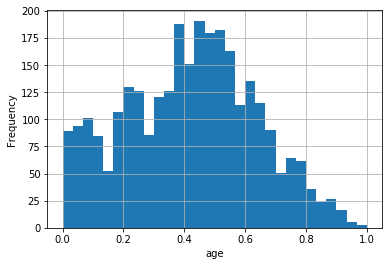

income


count    2913.000000
mean        0.341771
std         0.220164
min         0.000000
25%         0.166667
50%         0.322222
75%         0.466667
max         1.000000
Name: income, dtype: float64

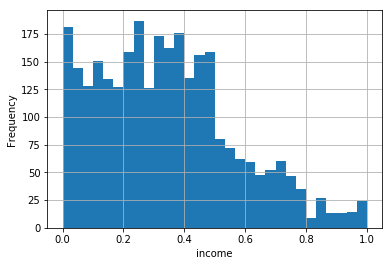

gender


,gender,count,percentage
0,0,1754,60.212839
1,1,1159,39.787161


Statistics when 5a8bc65990b245e5a138643cd4eb9837 was ineffective

age


count    2522.000000
mean        0.463382
std         0.201064
min         0.000000
25%         0.349398
50%         0.469880
75%         0.602410
max         1.000000
Name: age, dtype: float64

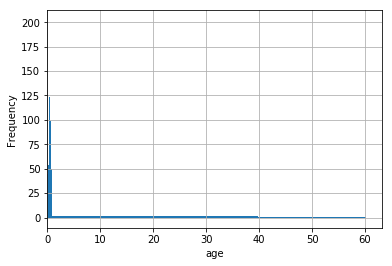

income


count    2522.000000
mean        0.457930
std         0.250275
min         0.000000
25%         0.266667
50%         0.455556
75%         0.644444
max         1.000000
Name: income, dtype: float64

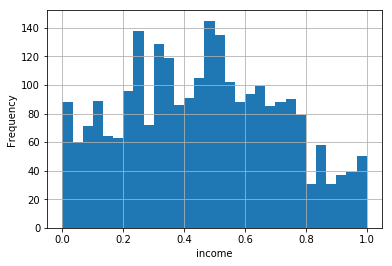

gender


,gender,count,percentage
0,0,1368,54.242665
1,1,1154,45.757335


,channels,difficulty,duration,id,offer_type,reward
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2


Statistics when fafdcd668e3743c1bb461111dcafc2a4 was effective

age


count    3760.000000
mean        0.447481
std         0.205239
min         0.000000
25%         0.313253
50%         0.457831
75%         0.578313
max         1.000000
Name: age, dtype: float64

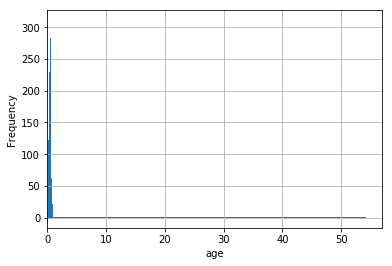

income


count    3760.000000
mean        0.413768
std         0.242027
min         0.000000
25%         0.233333
50%         0.400000
75%         0.577778
max         1.000000
Name: income, dtype: float64

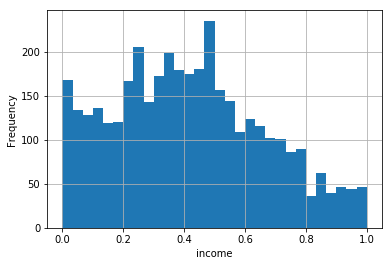

gender


,gender,count,percentage
0,0,2085,55.452128
1,1,1675,44.547872


Statistics when fafdcd668e3743c1bb461111dcafc2a4 was ineffective

age


count    1712.000000
mean        0.420687
std         0.216273
min         0.000000
25%         0.265060
50%         0.433735
75%         0.578313
max         1.000000
Name: age, dtype: float64

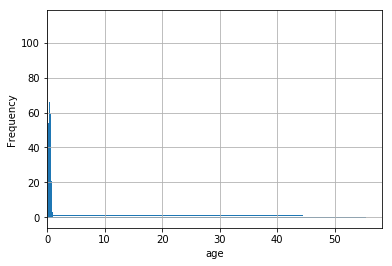

income


count    1712.000000
mean        0.350195
std         0.231602
min         0.000000
25%         0.155556
50%         0.322222
75%         0.488889
max         1.000000
Name: income, dtype: float64

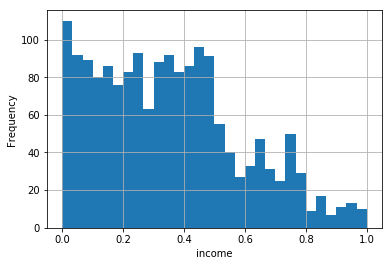

gender


,gender,count,percentage
0,0,1129,65.946262
1,1,583,34.053738


,channels,difficulty,duration,id,offer_type,reward
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0


Statistics when 3f207df678b143eea3cee63160fa8bed was effective

age


count    1751.000000
mean        0.447565
std         0.200623
min         0.000000
25%         0.313253
50%         0.445783
75%         0.590361
max         1.000000
Name: age, dtype: float64

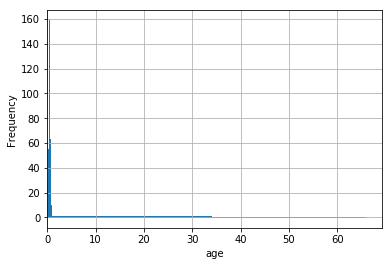

income


count    1751.000000
mean        0.412222
std         0.220973
min         0.000000
25%         0.261111
50%         0.400000
75%         0.555556
max         1.000000
Name: income, dtype: float64

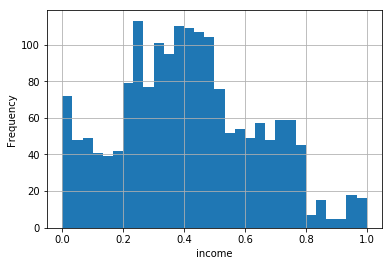

gender


,gender,count,percentage
0,0,982,56.082239
1,1,769,43.917761


Statistics when 3f207df678b143eea3cee63160fa8bed was ineffective

age


count    3692.000000
mean        0.436705
std         0.214457
min         0.000000
25%         0.289157
50%         0.457831
75%         0.590361
max         1.000000
Name: age, dtype: float64

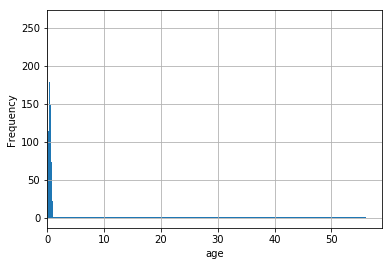

income


count    3692.000000
mean        0.383029
std         0.245322
min         0.000000
25%         0.188889
50%         0.355556
75%         0.536111
max         1.000000
Name: income, dtype: float64

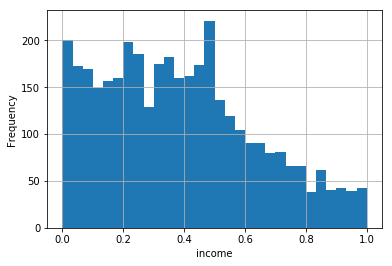

gender


,gender,count,percentage
0,0,2173,58.856988
1,1,1519,41.143012


,channels,difficulty,duration,id,offer_type,reward
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


Statistics when 2906b810c7d4411798c6938adc9daaa5 was effective

age


count    1830.000000
mean        0.457074
std         0.193356
min         0.000000
25%         0.325301
50%         0.469880
75%         0.590361
max         1.000000
Name: age, dtype: float64

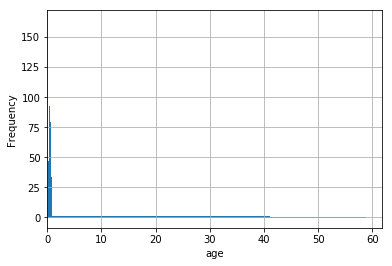

income


count    1830.000000
mean        0.433455
std         0.217851
min         0.000000
25%         0.277778
50%         0.422222
75%         0.597222
max         0.988889
Name: income, dtype: float64

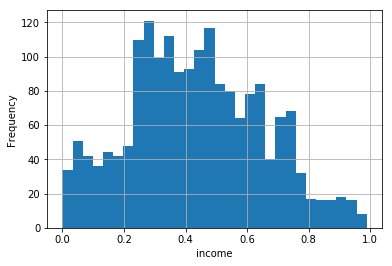

gender


,gender,count,percentage
0,0,988,53.989071
1,1,842,46.010929


Statistics when 2906b810c7d4411798c6938adc9daaa5 was ineffective

age


count    3577.000000
mean        0.423687
std         0.218511
min         0.000000
25%         0.265060
50%         0.433735
75%         0.578313
max         1.000000
Name: age, dtype: float64

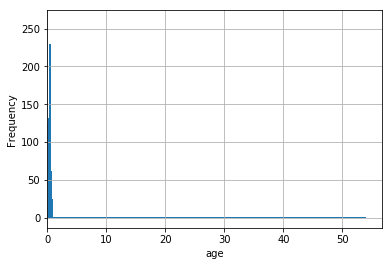

income


count    3577.000000
mean        0.374578
std         0.250157
min         0.000000
25%         0.166667
50%         0.344444
75%         0.522222
max         1.000000
Name: income, dtype: float64

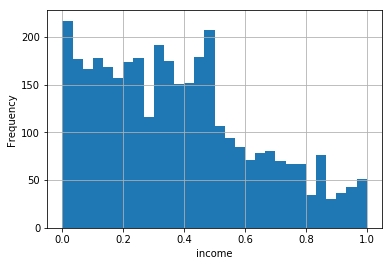

gender


,gender,count,percentage
0,0,2154,60.21806
1,1,1423,39.78194


,channels,difficulty,duration,id,offer_type,reward
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5


Statistics when f19421c1d4aa40978ebb69ca19b0e20d was effective

age


count    2958.000000
mean        0.452549
std         0.207313
min         0.000000
25%         0.313253
50%         0.457831
75%         0.590361
max         1.000000
Name: age, dtype: float64

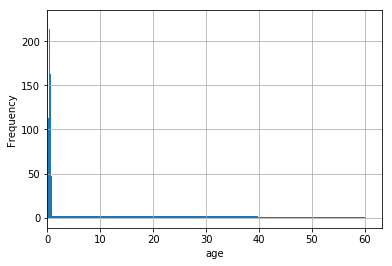

income


count    2958.000000
mean        0.428165
std         0.242072
min         0.000000
25%         0.244444
50%         0.411111
75%         0.600000
max         1.000000
Name: income, dtype: float64

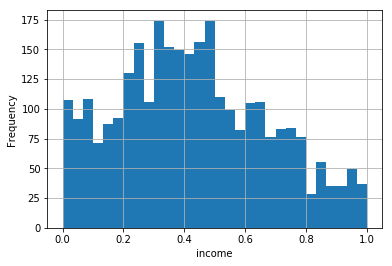

gender


,gender,count,percentage
0,0,1570,53.076403
1,1,1388,46.923597


Statistics when f19421c1d4aa40978ebb69ca19b0e20d was ineffective

age


count    2410.000000
mean        0.421517
std         0.214918
min         0.000000
25%         0.277108
50%         0.433735
75%         0.578313
max         0.987952
Name: age, dtype: float64

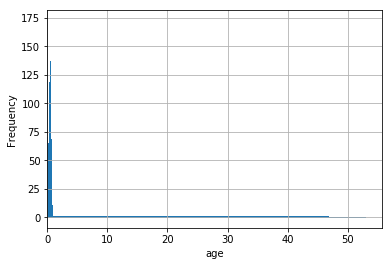

income


count    2410.000000
mean        0.353071
std         0.231400
min         0.000000
25%         0.166667
50%         0.322222
75%         0.500000
max         1.000000
Name: income, dtype: float64

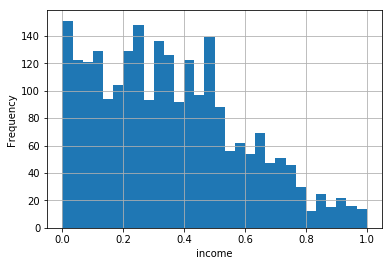

gender


,gender,count,percentage
0,0,1551,64.356846
1,1,859,35.643154


,channels,difficulty,duration,id,offer_type,reward
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10


Statistics when 4d5c57ea9a6940dd891ad53e9dbe8da0 was effective

age


count    2394.000000
mean        0.469557
std         0.195089
min         0.000000
25%         0.349398
50%         0.469880
75%         0.602410
max         0.987952
Name: age, dtype: float64

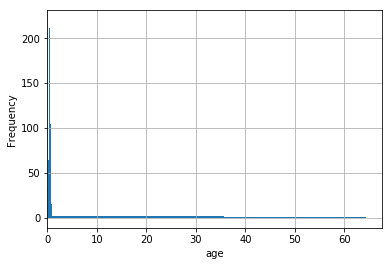

income


count    2394.000000
mean        0.470718
std         0.236960
min         0.000000
25%         0.288889
50%         0.466667
75%         0.633333
max         1.000000
Name: income, dtype: float64

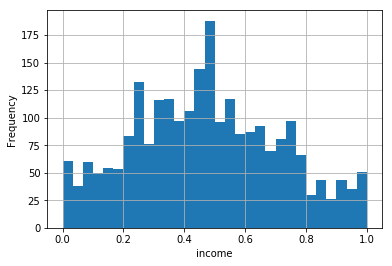

gender


,gender,count,percentage
0,1,1277,53.341688
1,0,1117,46.658312


Statistics when 4d5c57ea9a6940dd891ad53e9dbe8da0 was ineffective

age


count    3055.000000
mean        0.409082
std         0.218652
min         0.000000
25%         0.240964
50%         0.421687
75%         0.566265
max         0.975904
Name: age, dtype: float64

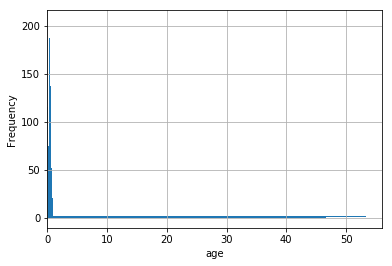

income


count    3055.000000
mean        0.329911
std         0.226417
min         0.000000
25%         0.144444
50%         0.300000
75%         0.466667
max         1.000000
Name: income, dtype: float64

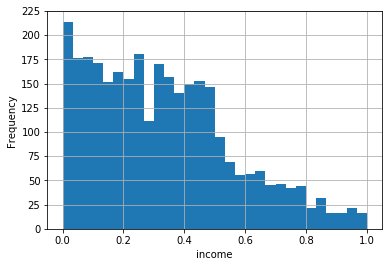

gender


,gender,count,percentage
0,0,2065,67.594108
1,1,990,32.405892


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10


Statistics when ae264e3637204a6fb9bb56bc8210ddfd was effective

age


count    2288.000000
mean        0.455004
std         0.199353
min         0.000000
25%         0.325301
50%         0.457831
75%         0.590361
max         0.987952
Name: age, dtype: float64

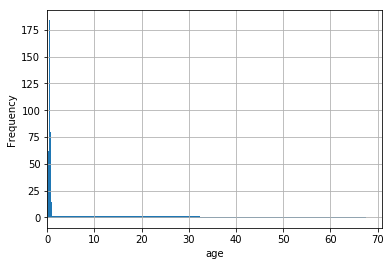

income


count    2288.000000
mean        0.447009
std         0.238290
min         0.000000
25%         0.266667
50%         0.444444
75%         0.611111
max         1.000000
Name: income, dtype: float64

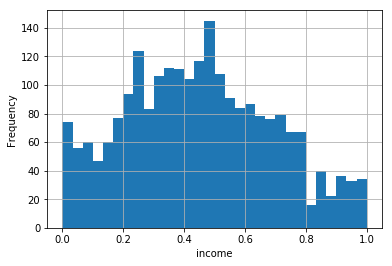

gender


,gender,count,percentage
0,1,1175,51.354895
1,0,1113,48.645105


Statistics when ae264e3637204a6fb9bb56bc8210ddfd was ineffective

age


count    3198.000000
mean        0.423405
std         0.212610
min         0.000000
25%         0.265060
50%         0.433735
75%         0.578313
max         0.951807
Name: age, dtype: float64

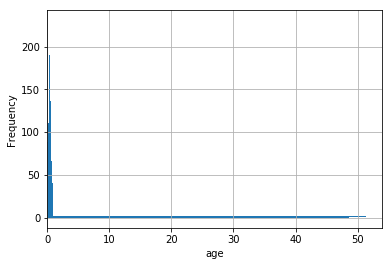

income


count    3198.000000
mean        0.360044
std         0.239228
min         0.000000
25%         0.166667
50%         0.333333
75%         0.500000
max         1.000000
Name: income, dtype: float64

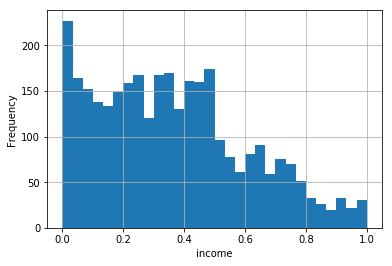

gender


,gender,count,percentage
0,0,2085,65.196998
1,1,1113,34.803002


,channels,difficulty,duration,id,offer_type,reward
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3


Statistics when 2298d6c36e964ae4a3e7e9706d1fb8c2 was effective

age


count    3581.000000
mean        0.442822
std         0.208492
min         0.000000
25%         0.301205
50%         0.457831
75%         0.590361
max         1.000000
Name: age, dtype: float64

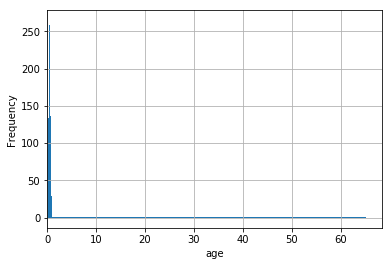

income


count    3581.000000
mean        0.406978
std         0.236935
min         0.000000
25%         0.233333
50%         0.400000
75%         0.566667
max         1.000000
Name: income, dtype: float64

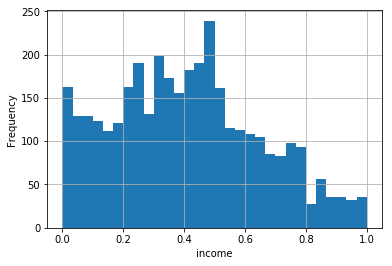

gender


,gender,count,percentage
0,0,1997,55.766546
1,1,1584,44.233454


Statistics when 2298d6c36e964ae4a3e7e9706d1fb8c2 was ineffective

age


count    1845.000000
mean        0.424638
std         0.215372
min         0.000000
25%         0.265060
50%         0.445783
75%         0.578313
max         0.987952
Name: age, dtype: float64

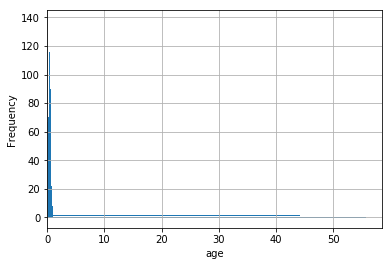

income


count    1845.000000
mean        0.369690
std         0.239970
min         0.000000
25%         0.177778
50%         0.344444
75%         0.511111
max         1.000000
Name: income, dtype: float64

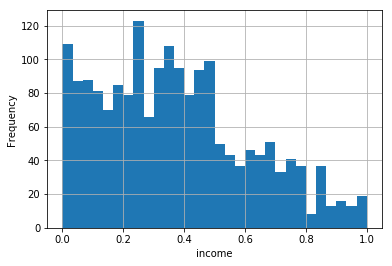

gender


,gender,count,percentage
0,0,1173,63.577236
1,1,672,36.422764


,channels,difficulty,duration,id,offer_type,reward
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5


Statistics when 9b98b8c7a33c4b65b9aebfe6a799e6d9 was effective

age


count    1833.000000
mean        0.457148
std         0.192983
min         0.000000
25%         0.325301
50%         0.457831
75%         0.590361
max         1.000000
Name: age, dtype: float64

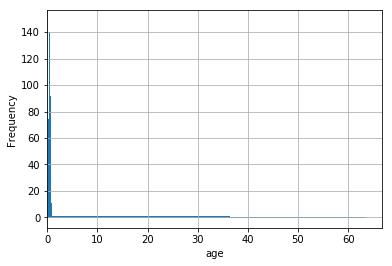

income


count    1833.000000
mean        0.433461
std         0.223666
min         0.000000
25%         0.266667
50%         0.422222
75%         0.600000
max         1.000000
Name: income, dtype: float64

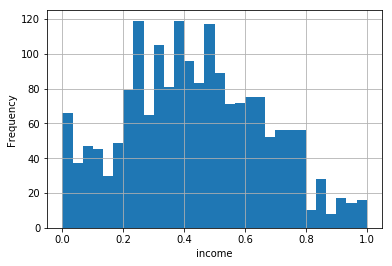

gender


,gender,count,percentage
0,0,971,52.973268
1,1,862,47.026732


Statistics when 9b98b8c7a33c4b65b9aebfe6a799e6d9 was ineffective

age


count    3623.000000
mean        0.427503
std         0.213882
min         0.000000
25%         0.265060
50%         0.445783
75%         0.578313
max         0.987952
Name: age, dtype: float64

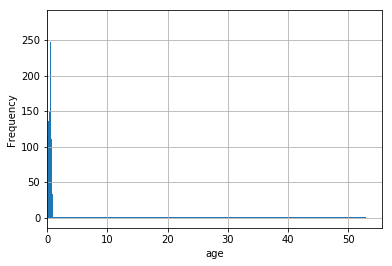

income


count    3623.000000
mean        0.368194
std         0.248321
min         0.000000
25%         0.166667
50%         0.333333
75%         0.511111
max         1.000000
Name: income, dtype: float64

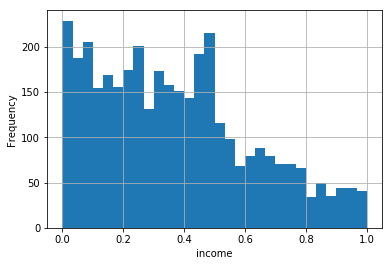

gender


,gender,count,percentage
0,0,2190,60.447143
1,1,1433,39.552857


,channels,difficulty,duration,id,offer_type,reward
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


Statistics when 0b1e1539f2cc45b7b9fa7c272da2e1d7 was effective

age


count    1194.000000
mean        0.466045
std         0.189675
min         0.000000
25%         0.349398
50%         0.469880
75%         0.590361
max         0.975904
Name: age, dtype: float64

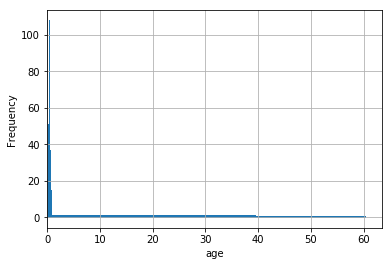

income


count    1194.000000
mean        0.446510
std         0.205849
min         0.000000
25%         0.288889
50%         0.444444
75%         0.600000
max         0.988889
Name: income, dtype: float64

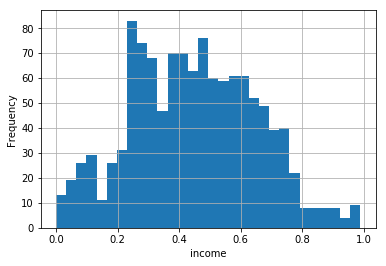

gender


,gender,count,percentage
0,0,624,52.261307
1,1,570,47.738693


Statistics when 0b1e1539f2cc45b7b9fa7c272da2e1d7 was ineffective

age


count    4317.000000
mean        0.431399
std         0.212329
min         0.000000
25%         0.277108
50%         0.445783
75%         0.578313
max         1.000000
Name: age, dtype: float64

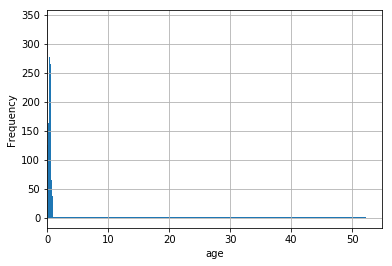

income


count    4317.000000
mean        0.377670
std         0.246464
min         0.000000
25%         0.177778
50%         0.344444
75%         0.522222
max         1.000000
Name: income, dtype: float64

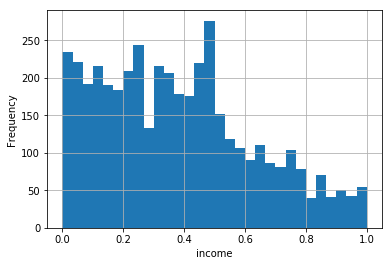

gender


,gender,count,percentage
0,0,2556,59.207783
1,1,1761,40.792217


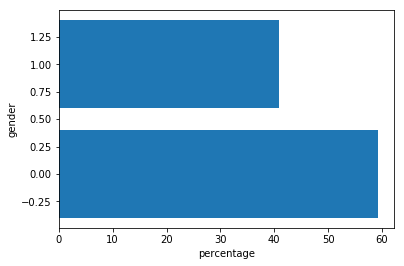

In [12]:
# study the distribution of age, income and gender for each offer twice, one time when the offer is successful
# and one when there is no response
numerical_features = ['age', 'income']
binary_features = ['gender']
for offer in offers:
    offer_info = portfolio[portfolio['id'] == offer]
    display(offer_info)
    offer_data =  clean_starbucks_df[clean_starbucks_df['offer_id'] == offer]
    
    print('Statistics when {} was effective\n'.format(offer))
    offer_data_positive = offer_data[offer_data['offer_success'] == 1]
    offer_continuous_features_stat(numerical_features, offer_data_positive);
    offer_binary_features_stat(binary_features, offer_data_positive);
    
    print('Statistics when {} was ineffective\n'.format(offer))
    offer_data_negative = offer_data[offer_data['offer_success'] == 0]
    offer_continuous_features_stat(numerical_features, offer_data_negative);
    offer_binary_features_stat(binary_features, offer_data_negative);

# Building Predictive model

In [10]:
#normalize the numerical data as features are of different scale which might affect the result
#Initialize a scaler, then apply it to the features
numerical = ['difficulty', 'duration', 'reward', 'age', 'income']
scaler = MinMaxScaler() # default=(0, 1)

clean_starbucks_df_scaled = pd.DataFrame(data = clean_starbucks_df)
clean_starbucks_df_scaled[numerical] = scaler.fit_transform(clean_starbucks_df[numerical])

C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [13]:
clean_starbucks_df_scaled.head()

,person,offer_id,offer_success,difficulty,duration,reward,channel_email,channel_mobile,channel_social,channel_web,...,offerType_informational,age,gender,income,membership_year_2013,membership_year_2014,membership_year_2015,membership_year_2016,membership_year_2017,membership_year_2018
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,0.00,0.000000,0.0,1,1,1,0,...,1,0.180723,0,0.466667,0,0,0,0,1,0
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,0,0.50,1.000000,0.2,1,1,1,1,...,0,0.180723,0,0.466667,0,0,0,0,1,0
2,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,0.00,0.142857,0.0,1,1,0,1,...,1,0.180723,0,0.466667,0,0,0,0,1,0
3,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,0,0.50,0.571429,0.2,1,1,0,1,...,0,0.180723,0,0.466667,0,0,0,0,1,0
4,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,0,0.25,0.285714,0.5,1,1,1,1,...,0,0.180723,0,0.466667,0,0,0,0,1,0


In [14]:
offer_success = clean_starbucks_df_scaled['offer_success']
features = clean_starbucks_df_scaled.drop(['offer_success', 'person', 'offer_id'], axis = 1)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    offer_success, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

In [16]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 43562 samples.
Testing set has 10891 samples.


In [17]:
#print accuracy & fscore of the naive model
naive_accuracy = accuracy_score(y_train,np.ones(len(y_train)))
naive_fscore = f1_score(y_train, np.ones(len(y_train)))
print('Accuracy of the naive model: {:.2f}'.format(naive_accuracy))
print('F-score of the naive model: {:.2f}'.format(naive_fscore))

Accuracy of the naive model: 0.45
F-score of the naive model: 0.62


In the following sections I used the code I used before in my first project at this nanodegree. some of the code was written by Udacity and some I had to complete as part of passing the project

In [18]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    #Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    #Calculate the total prediction time
    results['pred_time'] = end - start
            
    #Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    #Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    #Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, 0.5)
        
    #Compute F-score on the test set which is y_test
    results['f_test'] = fbeta_score(y_test, predictions_test, 0.5)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier trained on 435 samples.
RandomForestClassifier trained on 4356 samples.
RandomForestClassifier trained on 43562 samples.


C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 435 samples.


C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 4356 samples.


C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC trained on 43562 samples.
GaussianNB trained on 435 samples.
GaussianNB trained on 4356 samples.
GaussianNB trained on 43562 samples.


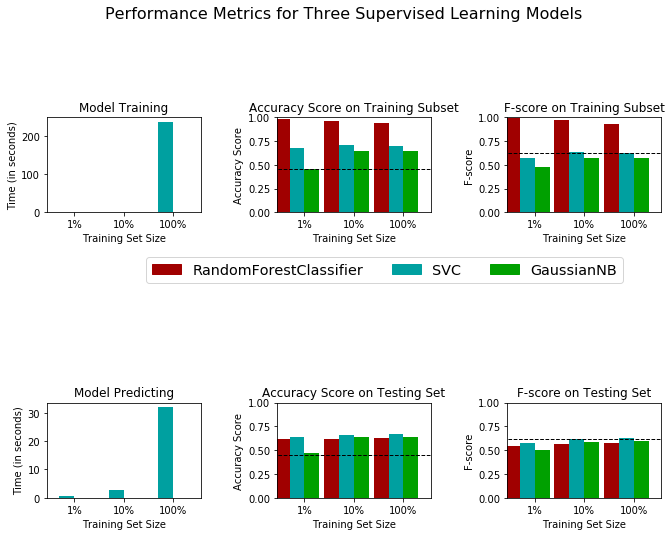

In [19]:
clf_A =  RandomForestClassifier(random_state=3)
clf_B = SVC(random_state=3)
clf_C = GaussianNB()

samples_100 = len(y_train)
samples_10 = int(0.1 * samples_100)
samples_1 = int(0.01 * samples_100)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, naive_accuracy, naive_fscore)

As shown in the graghs above, 

- Random Forest Classifier is doing the best on the training data which indicates overfitting as it doesn't do as good on the testing data. The main reason I believe behind the overfitting is because the training test was done on only 300 data whereas all the testing set was included in the process.

- On the testing set, SVC did slightly better than the others but since it takes more time to train, I will choose Random Forest to continue this project with

In [21]:
#Initialize the classifier
clf = RandomForestClassifier(random_state=3)
pprint(clf.get_params())

#Create the parameters list you wish to tune, using a dictionary if needed.
parameters = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_leaf': [3, 5],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 1000]
}

scorer = make_scorer(fbeta_score, beta=2)

#Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scoring=scorer,  n_jobs = 6)

#Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# show results
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 3,
 'verbose': 0,
 'warm_start': False}


C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\Amaal\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Unoptimized model
------
Accuracy score on testing data: 0.6318
F-score on testing data: 0.5790

Optimized Model
------
Final accuracy score on the testing data: 0.6695
Final F-score on the testing data: 0.6244


In [22]:
#hyperparameters of the best model
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=8,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

The hyperparameters tuning has increased the accuracy and fscore by 3.7% and 4.5% respectively. The results have slightly increased and the final results are not that high and that might be due to many reasons.

- performance of my machine prevented me to add more parameters or increase the range of the parameters' values in the hyperparameters tuning process.
- I only tried 3 machine learning algorithms and worked on improving only one of them. Trying other methods might outperform Random forest
- the variance can't be explained fully only by the features we have. Therefore, If we gather more features about the customers and the orders they usually make, we might know better what offers they might be interested in.

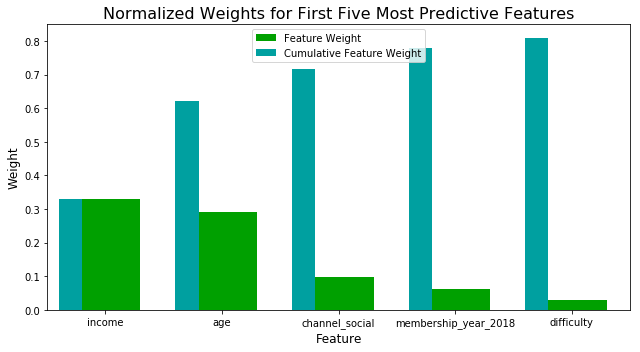

In [25]:
importances = best_clf.feature_importances_

vs.feature_plot(importances, X_train, y_train)

- The price of the offer had the highest influence on the customers' response to an offer and this makes sense as it's not smart to pay a high amount of money to get an offer when you can just not spend a penny and save your money to the things you really need and want.

- The second factor is the membership year 2018, this also makes sense as the most recent users registered on the mobile app are most likely to be the most active users during the experiement.

- I expected that gender won't have a great impact and the data proves it. Also, as expect age and gender are effective factors on offers. 